In [1]:
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
cancer_data = pd.read_csv("../datasets/cancer.csv")
print(cancer_data.shape)
cancer_labels = np.array([1 if l == 'M' else 0 for l in cancer_data['label'].values])
cancer_features = cancer_data.drop(['label'], axis=1).values
cancer_data.head()

(569, 31)


,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
spam_data = pd.read_csv("../datasets/spam.csv")
print(spam_data.shape)
spam_labels = spam_data['label'].values
spam_features = spam_data.drop(['label'], axis=1).values
spam_data.head()

(4601, 58)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [4]:
def roc(y_pr, y_true):
    tps = []
    fps = []
    y_true[y_true == 0]
    gt_true = len(y_true[y_true == 1])
    gt_false = len(y_true[y_true == 0])
    ys = zip(y_pr, y_true)
    ys = sorted(ys)
    true_positive = gt_true
    false_positive = gt_false
    fps.append(false_positive / gt_false)
    tps.append(true_positive / gt_true)
    prev_p = None
    i = 0
    while i < len(ys):
        y_p, y_t = ys[i]
        prev_p = y_p
        while i < len(ys) and y_p == prev_p:
            if y_t == 1:
                true_positive -= 1
            if y_t == 0:
                false_positive -= 1
            i += 1
            if i == len(ys):
                break
            y_p, y_t = ys[i]
        prev_p = y_p
        fps.append(false_positive / gt_false)
        tps.append(true_positive / gt_true)
    return tps[::-1], fps[::-1]

def roc_auc(y_pr, y_true):
    tps, fps = roc(y_pr, y_true)
    prev_tp = tps[0]
    prev_fp = fps[0]
    area = 0
    for tp, fp in zip(tps, fps):
        area += (fp - prev_fp) * (prev_tp + tp) / 2
        prev_tp = tp
        prev_fp = fp
    return area

In [5]:
cancer_features_tr, cancer_features_te, cancer_labels_tr, cancer_labels_te = train_test_split(cancer_features, cancer_labels, train_size=0.8)
spam_features_tr, spam_features_te, spam_labels_tr, spam_labels_te = train_test_split(spam_features, spam_labels, train_size=0.8)

In [6]:
def misclassify(ys):
    c = max(Counter(ys).values())
    return 1 - c / len(ys)

def entropy(ys):
    ent = 0
    for l in Counter(ys).values():
        p = l / len(ys)
        ent -= p * np.log(p)
    return ent

def gini(ys):
    ent = 0
    for l in Counter(ys).values():
        p = l / len(ys)
        ent += p * (1 - p)
    return ent

In [7]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=6, impurity=gini):
        self.max_depth = max_depth
        self.impurity = impurity

    def fit(self, X, y):
        self.prob = Counter(y)[1] / len(y)
        self.depth = 0
        self.is_terminal = True
        if self.max_depth == 0:
            self.is_terminal = True
            return self
        node_gain = self.impurity(y) * len(y)
        max_gain = 0
        for feature_ind in range(X.shape[1]):
            features_values = sorted(list(set(X[:, feature_ind])))
            for th in features_values:
                left_y = y[X[:, feature_ind] <= th]
                right_y = y[X[:, feature_ind] > th]
                if len(left_y) == 0 or len(right_y) == 0:
                    continue
                left_gain = self.impurity(left_y)
                right_gain = self.impurity(right_y)
                gain = node_gain - left_gain * len(left_y) - right_gain * len(right_y)
                if max_gain < gain:
                    max_gain = gain
                    self.feature_ind = feature_ind
                    self.th = th
        if max_gain > 0:
            self.is_terminal = False
            self.left = DecisionTreeClassifier(self.max_depth - 1, self.impurity)
            self.right = DecisionTreeClassifier(self.max_depth - 1, self.impurity)
            self.left.fit(X[X[:, self.feature_ind] <= self.th], y[X[:, self.feature_ind] <= self.th])
            self.right.fit(X[X[:, self.feature_ind] > self.th], y[X[:, self.feature_ind] > self.th])
            self.depth = max(self.left.depth, self.right.depth) + 1
        return self
    
    def _prob_to_lab(self, p):
        return 1 if p >= 0.5 else 0

    def predict(self, X, depth=-1):
        return np.around(self.predict_proba(X, depth))
        
    def predict_proba(self, X, depth=-1):
        if self.is_terminal or depth == 0:
            return np.array([self.prob for _ in range(X.shape[0])])
        else:
            y = np.array([0.0 for _ in range(X.shape[0])])
            y[X[:, self.feature_ind] <= self.th] = self.left.predict_proba(X[X[:, self.feature_ind] <= self.th], depth - 1)
            y[X[:, self.feature_ind] > self.th] = self.right.predict_proba(X[X[:, self.feature_ind] > self.th], depth - 1)
            return y

In [11]:
class RandomForest:
    def __init__(self, num=1, max_depth=6, impurity=gini, data_size_ratio=0.8, features_ratio=0.8):
        self.max_depth = max_depth
        self.impurity = impurity
        self.data_size_ratio = data_size_ratio
        self.features_ratio = features_ratio
        self.trees = [DecisionTreeClassifier(max_depth, impurity) for _ in range(num)]
        self.feature_inds = []
        
    def fit(self, X, y):
        for i, tree in enumerate(self.trees):
            X_tr, _, y_tr, _ = train_test_split(X, y, train_size=self.data_size_ratio)
            features_num = X.shape[1]
            features = np.random.permutation(features_num)[:int(features_num * self.features_ratio)]
            self.feature_inds.append(features)
            tree.fit(X_tr[:, features], y_tr)
        return self
            
    def predict_proba(self, X, num=None, depth=-1):
        ans = np.zeros(X.shape[0])
        trees_num = len(self.trees) if num is None else min(len(self.trees), num)
        for tree, features in zip(self.trees[:trees_num], self.feature_inds[:trees_num]):
            ans += tree.predict_proba(X[:, features], depth)
        return ans / trees_num
    
    def predict(self, X, num=None, depth=-1):
        return np.around(self.predict_proba(X, num, depth))

In [12]:
def roc_on_forest(forest, X_tr, y_tr, X_te, y_te):
    forest.fit(X_tr, y_tr)
    tps, fps = roc(forest.predict_proba(X_te), y_te)
    plt.plot(fps, tps)
    plt.show()

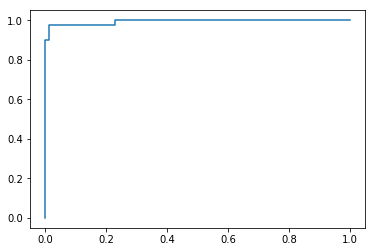

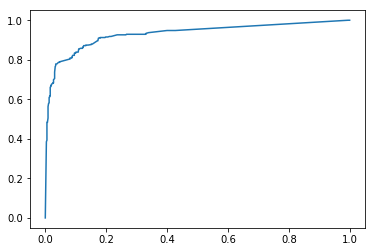

In [13]:
roc_on_forest(RandomForest(20, 3), cancer_features_tr, cancer_labels_tr, cancer_features_te, cancer_labels_te)
roc_on_forest(RandomForest(20, 3), spam_features_tr, spam_labels_tr, spam_features_te, spam_labels_te)

In [14]:
cancer_forest_100_10_85_85 = RandomForest(100, 10, data_size_ratio=0.85, features_ratio=0.85).fit(cancer_features_tr, cancer_labels_tr)

In [15]:
spam_forest_100_10_85_85 = RandomForest(100, 10, data_size_ratio=0.85, features_ratio=0.85).fit(spam_features_tr, spam_labels_tr)

In [16]:
def find_best(forest, X_te, y_te):
    for trees_num in [5, 10, 20, 30, 50, 100]:
        for depth in [2, 3, 5, 7, 10]:
            y_pr = forest.predict_proba(X_te, trees_num, depth)
            auc = roc_auc(y_pr, y_te)
            print(f"Num: {trees_num}, Depth: {depth}, AUC: {auc}")

In [17]:
find_best(cancer_forest_100_10_85_85, cancer_features_te, cancer_labels_te)

Num: 5, Depth: 2, AUC: 0.98125
Num: 5, Depth: 3, AUC: 0.9966216216216217
Num: 5, Depth: 5, AUC: 0.9829391891891892
Num: 5, Depth: 7, AUC: 0.9834459459459459
Num: 5, Depth: 10, AUC: 0.9834459459459459
Num: 10, Depth: 2, AUC: 0.9812500000000001
Num: 10, Depth: 3, AUC: 0.9949324324324325
Num: 10, Depth: 5, AUC: 0.9817567567567568
Num: 10, Depth: 7, AUC: 0.9827702702702703
Num: 10, Depth: 10, AUC: 0.9827702702702703
Num: 20, Depth: 2, AUC: 0.9820945945945946
Num: 20, Depth: 3, AUC: 0.9939189189189189
Num: 20, Depth: 5, AUC: 0.9831081081081082
Num: 20, Depth: 7, AUC: 0.983445945945946
Num: 20, Depth: 10, AUC: 0.983445945945946
Num: 30, Depth: 2, AUC: 0.9819256756756757
Num: 30, Depth: 3, AUC: 0.9922297297297297
Num: 30, Depth: 5, AUC: 0.9826013513513513
Num: 30, Depth: 7, AUC: 0.9826013513513514
Num: 30, Depth: 10, AUC: 0.9829391891891892
Num: 50, Depth: 2, AUC: 0.9822635135135136
Num: 50, Depth: 3, AUC: 0.9922297297297297
Num: 50, Depth: 5, AUC: 0.9814189189189189
Num: 50, Depth: 7, AUC: 0

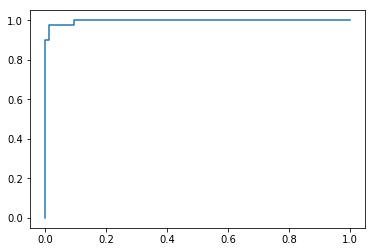

In [21]:
tps, fps = roc(cancer_forest_100_10_85_85.predict_proba(cancer_features_te, 5, 3), cancer_labels_te)
plt.plot(fps, tps)
plt.show()

In [19]:
find_best(spam_forest_100_10_85_85, spam_features_te, spam_labels_te)

Num: 5, Depth: 2, AUC: 0.9097597597597599
Num: 5, Depth: 3, AUC: 0.9316546054250973
Num: 5, Depth: 5, AUC: 0.9517328804214051
Num: 5, Depth: 7, AUC: 0.9591468517698027
Num: 5, Depth: 10, AUC: 0.9599788312903063
Num: 10, Depth: 2, AUC: 0.9191650667060505
Num: 10, Depth: 3, AUC: 0.9319302909466844
Num: 10, Depth: 5, AUC: 0.9557524737852607
Num: 10, Depth: 7, AUC: 0.9622433909319159
Num: 10, Depth: 10, AUC: 0.9666814355338962
Num: 20, Depth: 2, AUC: 0.9194259833604098
Num: 20, Depth: 3, AUC: 0.9326342736178803
Num: 20, Depth: 5, AUC: 0.9576625806134006
Num: 20, Depth: 7, AUC: 0.9663319056761697
Num: 20, Depth: 10, AUC: 0.9685669275833219
Num: 30, Depth: 2, AUC: 0.9228942056810909
Num: 30, Depth: 3, AUC: 0.9327425786442183
Num: 30, Depth: 5, AUC: 0.9581327228868217
Num: 30, Depth: 7, AUC: 0.9676414119037079
Num: 30, Depth: 10, AUC: 0.9707034903756219
Num: 50, Depth: 2, AUC: 0.9224289863634126
Num: 50, Depth: 3, AUC: 0.9333013341210065
Num: 50, Depth: 5, AUC: 0.9572564367646333
Num: 50, Dep

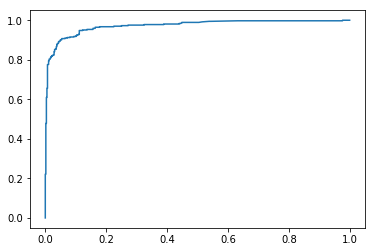

In [22]:
tps, fps = roc(spam_forest_100_10_85_85.predict_proba(spam_features_te, 100, 10), spam_labels_te)
plt.plot(fps, tps)
plt.show()